## Getting the data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/MyDrive/proyecto_inteligencia/heatmap2/entrenamiento.zip'
!unzip '/content/drive/MyDrive/proyecto_inteligencia/heatmap2/validacion.zip'

Archive:  /content/drive/MyDrive/proyecto_inteligencia/heatmap2/entrenamiento.zip
   creating: content/entrenamiento/
  inflating: content/entrenamiento/ent_0102.png  
  inflating: content/entrenamiento/ent_0643.png  
  inflating: content/entrenamiento/ent_1658.png  
  inflating: content/entrenamiento/ent_0367.png  
  inflating: content/entrenamiento/ent_1334.png  
  inflating: content/entrenamiento/ent_1435.png  
  inflating: content/entrenamiento/ent_2527.png  
  inflating: content/entrenamiento/ent_2228.png  
  inflating: content/entrenamiento/ent_2083.png  
  inflating: content/entrenamiento/ent_1181.png  
  inflating: content/entrenamiento/ent_0106.png  
  inflating: content/entrenamiento/ent_1335.png  
  inflating: content/entrenamiento/ent_2750.png  
  inflating: content/entrenamiento/ent_0536.png  
  inflating: content/entrenamiento/ent_0474.png  
  inflating: content/entrenamiento/ent_1496.png  
  inflating: content/entrenamiento/ent_0553.png  
  inflating: content/entrenamien

## Dataset preparation

In [ ]:
import torch
from torch.utils.data import DataLoader, Dataset
import numpy as np
from PIL import Image

from __future__ import print_function
from __future__ import division
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

from tqdm import tqdm, trange

PyTorch Version:  2.1.0+cu118
Torchvision Version:  0.16.0+cu118


In [ ]:
train_labels = np.load('/content/drive/MyDrive/proyecto_inteligencia/train_labels.npy')
val_labels = np.load('/content/drive/MyDrive/proyecto_inteligencia/val_labels.npy')

print(train_labels)

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, image_folder, label_file, transform=None, is_train=True):
        self.image_folder = image_folder
        self.labels = np.load(label_file) - 1
        self.transform = transform
        self.is_train = is_train

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        if self.is_train:
            img_path = self.image_folder + '/ent_{:04d}.png'.format(index)
        else:
            img_path = self.image_folder + '/val_{:04d}.png'.format(index)

        image = Image.open(img_path)
        label = self.labels[index]

        if self.transform is not None:
            image = self.transform(image)

        return image, label

In [ ]:
# Transformations (NO data augmentation)
transform = transforms.Compose([
    transforms.Resize((229, 229)),
    transforms.ToTensor(),
    #transforms.Grayscale(),      ###
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Transformations (data augmentation)
transform_train = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.RandomHorizontalFlip(),             
    transforms.ToTensor(),
    #transforms.Grayscale(),      ###
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_val = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    #transforms.Grayscale(),      ###
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# Files path
train_folder = '/content/content/entrenamiento'
train_labels_file = '/content/drive/MyDrive/proyecto_inteligencia/train_labels.npy'
val_folder = '/content/content/validacion'
val_labels_file = '/content/drive/MyDrive/proyecto_inteligencia/val_labels.npy'

In [ ]:
train_dataset = CustomDataset(train_folder, train_labels_file, transform, is_train=True)
val_dataset = CustomDataset(val_folder, val_labels_file, transform, is_train=False)

## Setup and model selection

In [ ]:
# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "vgg"

# Number of classes in the dataset
num_classes = 6

# Batch size for training (change depending on how much memory you have)
batch_size = 32

# Number of epochs to train for
num_epochs = 50

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = False #True

## DataLoaders

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

dataloaders_dict = {'train': train_loader, 'val': val_loader}

## CNN implementation functions

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False, patience = 6):
    since = time.time()

    val_acc_history = []
    train_loss_history = []  # Train Loss history                         #
    val_loss_history = []  # Validation Loss history                      #

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        train_loss_sum = 0.0  #  Training loss acumulation variable   #

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                # Calculate train loss                                #
                if phase == 'train':                                  #
                    train_loss_sum += loss.item() * inputs.size(0)    #

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)  #  save validation loss                    #

        train_loss = train_loss_sum / len(dataloaders['train'].dataset)  # Calculate train loss    #
        train_loss_history.append(train_loss)  # save train loss                               #
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, train_loss_history, val_loss_history

In [ ]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [ ]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
print(model_ft)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg11_bn-6002323d.pth" to /root/.cache/torch/hub/checkpoints/vgg11_bn-6002323d.pth
100%|██████████| 507M/507M [00:07<00:00, 73.5MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

## Model creation

In [ ]:
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
torch.cuda.is_available()
torch.cuda.get_device_name(0)

'Tesla T4'

In [ ]:
# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 features.0.weight
	 features.0.bias
	 features.1.weight
	 features.1.bias
	 features.4.weight
	 features.4.bias
	 features.5.weight
	 features.5.bias
	 features.8.weight
	 features.8.bias
	 features.9.weight
	 features.9.bias
	 features.11.weight
	 features.11.bias
	 features.12.weight
	 features.12.bias
	 features.15.weight
	 features.15.bias
	 features.16.weight
	 features.16.bias
	 features.18.weight
	 features.18.bias
	 features.19.weight
	 features.19.bias
	 features.22.weight
	 features.22.bias
	 features.23.weight
	 features.23.bias
	 features.25.weight
	 features.25.bias
	 features.26.weight
	 features.26.bias
	 classifier.0.weight
	 classifier.0.bias
	 classifier.3.weight
	 classifier.3.bias
	 classifier.6.weight
	 classifier.6.bias


## Training and evaluating

In [ ]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
#model_ft, hist, train_l, val_l = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))
model_ft, hist, train_l, val_l = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs)

Epoch 0/49
----------
train Loss: 0.4492 Acc: 0.8357
val Loss: 0.2681 Acc: 0.8950

Epoch 1/49
----------
train Loss: 0.1451 Acc: 0.9393
val Loss: 0.1946 Acc: 0.9300

Epoch 2/49
----------
train Loss: 0.1074 Acc: 0.9525
val Loss: 0.2211 Acc: 0.9295

Epoch 3/49
----------
train Loss: 0.0954 Acc: 0.9561
val Loss: 0.3016 Acc: 0.9115

Epoch 4/49
----------
train Loss: 0.0785 Acc: 0.9686
val Loss: 0.3260 Acc: 0.9025

Epoch 5/49
----------
train Loss: 0.0676 Acc: 0.9721
val Loss: 0.2034 Acc: 0.9325

Epoch 6/49
----------
train Loss: 0.0550 Acc: 0.9782
val Loss: 0.2288 Acc: 0.9265

Epoch 7/49
----------
train Loss: 0.0564 Acc: 0.9789
val Loss: 0.3876 Acc: 0.8780

Epoch 8/49
----------
train Loss: 0.0501 Acc: 0.9807
val Loss: 0.3956 Acc: 0.8805

Epoch 9/49
----------
train Loss: 0.0430 Acc: 0.9850
val Loss: 0.4080 Acc: 0.8805

Epoch 10/49
----------
train Loss: 0.0386 Acc: 0.9850
val Loss: 0.3275 Acc: 0.9245

Epoch 11/49
----------
train Loss: 0.0387 Acc: 0.9857
val Loss: 0.3270 Acc: 0.9195

Ep

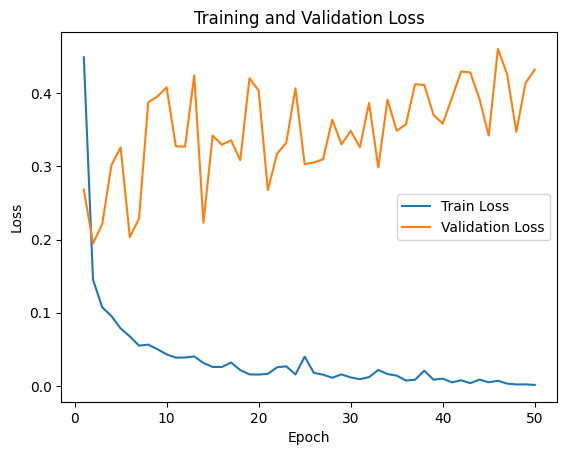

In [ ]:
import matplotlib.pyplot as plt

# Graficar las curvas de pérdida
plt.plot(range(1, num_epochs + 1), train_l, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_l, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
hist_path = '/content/drive/MyDrive/proyecto_inteligencia/hist_8.pth'
hist = torch.load(hist_path)
model_path = '/content/drive/MyDrive/proyecto_inteligencia/model_8.pth'
model_ft = torch.load(model_path)
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

In [ ]:
print(type(hist))
print(hist)

In [ ]:
torch.save(model_ft, '/content/drive/MyDrive/proyecto_inteligencia/model_vggH2_FE_F.pth')
torch.save(hist, '/content/drive/MyDrive/proyecto_inteligencia/hist_vggH2_FE_F.pth')
torch.save(train_l, '/content/drive/MyDrive/proyecto_inteligencia/train_loss_vggH2_FE_F.pth')
torch.save(val_l, '/content/drive/MyDrive/proyecto_inteligencia/val_loss_vggH2_FE_F.pth')

## Pre-trained and not-pre-trained model comparison (idk if this part really works)

In [ ]:
# Initialize the non-pretrained version of the model used for this run
scratch_model,_ = initialize_model(model_name, num_classes, feature_extract=False, use_pretrained=False)
scratch_model = scratch_model.to(device)
scratch_optimizer = optim.SGD(scratch_model.parameters(), lr=0.001, momentum=0.9)
scratch_criterion = nn.CrossEntropyLoss()
_,scratch_hist = train_model(scratch_model, dataloaders_dict, scratch_criterion, scratch_optimizer, num_epochs=num_epochs, is_inception=(model_name=="inception"))

# Plot the training curves of validation accuracy vs. number
#  of training epochs for the transfer learning method and
#  the model trained from scratch
ohist = []
shist = []

ohist = [h.cpu().numpy() for h in hist]
shist = [h.cpu().numpy() for h in scratch_hist]

plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,num_epochs+1),ohist,label="Pretrained")
plt.plot(range(1,num_epochs+1),shist,label="Scratch")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

## Training And plot (again, im not really sure if this code is correct)

In [ ]:
MODEL_PATH= "/content/content/inceptionV3proyecto.pth"

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
bestLoss = 999999;

train_losses = []
val_losses = []
for epoch in trange(num_epochs, desc="Training"):
    train_loss = 0.0
    for batch in tqdm(dataloaders_dict['train'], desc=f"Epoch {epoch + 1} in training", leave=False):
        x, y = batch
        x, y = x.to(device), y.to(device)
        y_hat = model_ft(x)
        loss = criterion(y_hat, y)

        train_loss += loss.detach().cpu().item() / len(dataloaders_dict['train'])

        optimizer_ft.zero_grad()
        loss.backward()
        optimizer_ft.step()
    train_losses.append(train_loss)

    print(f"Epoch {epoch + 1}/{num_epochs} loss: {train_loss:.2f}")

# Test loop
    with torch.no_grad():
        correct, total = 0, 0
        test_loss = 0.0
        for batch in tqdm(dataloaders_dict['val'], desc="Testing"):
            x, y = batch
            x, y = x.to(device), y.to(device)
            y_hat = model_ft(x)
            loss = criterion(y_hat, y)
            test_loss += loss.detach().cpu().item() / len(dataloaders_dict['val'])

            correct += torch.sum(torch.argmax(y_hat, dim=1) == y).detach().cpu().item()
            total += len(x)
        print(f"Test loss: {test_loss:.2f}")
        print(f"Test accuracy: {correct / total * 100:.2f}%")
        val_losses.append(test_loss)
        if test_loss < bestLoss:
            print("Model Saved!")
            torch.save(model_ft.state_dict(), MODEL_PATH)
            bestLoss = test_loss


Epoch 1 in training: 100%|██████████| 88/88 [00:32<00:00,  2.79it/s]
                                                                    

Epoch 1/50 loss: 0.23



Training:   2%|▏         | 1/50 [00:54<44:17, 54.23s/it]

Test loss: 0.46
Test accuracy: 81.55%
Model Saved!



Epoch 2 in training: 100%|██████████| 88/88 [00:30<00:00,  3.55it/s]
                                                                    

Epoch 2/50 loss: 0.22



Training:   4%|▍         | 2/50 [01:47<42:51, 53.57s/it]

Test loss: 0.46
Test accuracy: 81.50%



Epoch 3 in training: 100%|██████████| 88/88 [00:30<00:00,  3.51it/s]
                                                                    

Epoch 3/50 loss: 0.22



Training:   6%|▌         | 3/50 [02:41<42:07, 53.79s/it]

Test loss: 0.46
Test accuracy: 81.15%



Epoch 4 in training: 100%|██████████| 88/88 [00:31<00:00,  3.51it/s]
                                                                    

Epoch 4/50 loss: 0.22



Testing: 100%|██████████| 63/63 [00:23<00:00,  2.64it/s]


Test loss: 0.46
Test accuracy: 81.45%
Model Saved!


Epoch 5 in training: 100%|██████████| 88/88 [00:31<00:00,  3.48it/s]
                                                                    

Epoch 5/50 loss: 0.21



Testing: 100%|██████████| 63/63 [00:22<00:00,  2.79it/s]


Test loss: 0.45
Test accuracy: 81.65%
Model Saved!


Epoch 6 in training: 100%|██████████| 88/88 [00:31<00:00,  3.53it/s]
                                                                    

Epoch 6/50 loss: 0.21



Training:  12%|█▏        | 6/50 [05:24<39:36, 54.02s/it]

Test loss: 0.46
Test accuracy: 81.30%



Epoch 7 in training: 100%|██████████| 88/88 [00:31<00:00,  3.39it/s]
                                                                    

Epoch 7/50 loss: 0.21



Testing: 100%|██████████| 63/63 [00:21<00:00,  2.89it/s]


Test loss: 0.45
Test accuracy: 81.75%
Model Saved!


Epoch 8 in training: 100%|██████████| 88/88 [00:32<00:00,  3.08it/s]
                                                                    

Epoch 8/50 loss: 0.20



Testing: 100%|██████████| 63/63 [00:21<00:00,  2.88it/s]


Test loss: 0.45
Test accuracy: 82.10%
Model Saved!


Epoch 9 in training: 100%|██████████| 88/88 [00:32<00:00,  2.83it/s]
                                                                    

Epoch 9/50 loss: 0.20



Training:  18%|█▊        | 9/50 [08:05<36:53, 53.99s/it]

Test loss: 0.45
Test accuracy: 81.80%



Epoch 10 in training: 100%|██████████| 88/88 [00:31<00:00,  2.78it/s]
                                                                     

Epoch 10/50 loss: 0.20



Training:  20%|██        | 10/50 [09:00<36:04, 54.11s/it]

Test loss: 0.45
Test accuracy: 81.65%



Epoch 11 in training: 100%|██████████| 88/88 [00:31<00:00,  3.04it/s]
                                                                     

Epoch 11/50 loss: 0.19



Testing: 100%|██████████| 63/63 [00:22<00:00,  2.77it/s]


Test loss: 0.45
Test accuracy: 81.95%
Model Saved!


Epoch 12 in training: 100%|██████████| 88/88 [00:31<00:00,  3.42it/s]
                                                                     

Epoch 12/50 loss: 0.19



Testing: 100%|██████████| 63/63 [00:23<00:00,  2.73it/s]


Test loss: 0.44
Test accuracy: 82.75%
Model Saved!


Epoch 13 in training: 100%|██████████| 88/88 [00:32<00:00,  3.47it/s]
                                                                     

Epoch 13/50 loss: 0.19



Training:  26%|██▌       | 13/50 [11:45<33:42, 54.66s/it]

Test loss: 0.45
Test accuracy: 82.00%



Epoch 14 in training: 100%|██████████| 88/88 [00:31<00:00,  3.42it/s]
                                                                     

Epoch 14/50 loss: 0.19



Training:  28%|██▊       | 14/50 [12:39<32:50, 54.72s/it]

Test loss: 0.45
Test accuracy: 81.45%



Epoch 15 in training: 100%|██████████| 88/88 [00:31<00:00,  3.44it/s]
                                                                     

Epoch 15/50 loss: 0.18



Training:  30%|███       | 15/50 [13:34<31:58, 54.81s/it]

Test loss: 0.45
Test accuracy: 82.25%



Epoch 16 in training: 100%|██████████| 88/88 [00:32<00:00,  3.46it/s]
                                                                     

Epoch 16/50 loss: 0.18



Training:  32%|███▏      | 16/50 [14:30<31:10, 55.00s/it]

Test loss: 0.45
Test accuracy: 82.10%



Epoch 17 in training: 100%|██████████| 88/88 [00:31<00:00,  3.44it/s]
                                                                     

Epoch 17/50 loss: 0.18



Training:  34%|███▍      | 17/50 [15:24<30:11, 54.90s/it]

Test loss: 0.45
Test accuracy: 81.50%



Epoch 18 in training: 100%|██████████| 88/88 [00:32<00:00,  3.38it/s]
                                                                     

Epoch 18/50 loss: 0.18



Testing: 100%|██████████| 63/63 [00:23<00:00,  2.70it/s]


Test loss: 0.44
Test accuracy: 81.80%
Model Saved!


Epoch 19 in training: 100%|██████████| 88/88 [00:31<00:00,  3.44it/s]
                                                                     

Epoch 19/50 loss: 0.17



Training:  38%|███▊      | 19/50 [17:15<28:26, 55.05s/it]

Test loss: 0.45
Test accuracy: 81.45%



Epoch 20 in training: 100%|██████████| 88/88 [00:32<00:00,  3.43it/s]
                                                                     

Epoch 20/50 loss: 0.17



Testing: 100%|██████████| 63/63 [00:23<00:00,  2.73it/s]


Test loss: 0.44
Test accuracy: 82.85%
Model Saved!


Epoch 21 in training: 100%|██████████| 88/88 [00:32<00:00,  3.41it/s]
                                                                     

Epoch 21/50 loss: 0.17



Training:  42%|████▏     | 21/50 [19:06<26:39, 55.15s/it]

Test loss: 0.44
Test accuracy: 82.20%



Epoch 22 in training: 100%|██████████| 88/88 [00:32<00:00,  3.36it/s]
                                                                     

Epoch 22/50 loss: 0.17



Testing: 100%|██████████| 63/63 [00:22<00:00,  2.81it/s]


Test loss: 0.44
Test accuracy: 82.75%
Model Saved!


Epoch 23 in training: 100%|██████████| 88/88 [00:32<00:00,  3.26it/s]
                                                                     

Epoch 23/50 loss: 0.17



Training:  46%|████▌     | 23/50 [20:55<24:44, 55.00s/it]

Test loss: 0.44
Test accuracy: 82.65%



Epoch 24 in training: 100%|██████████| 88/88 [00:32<00:00,  3.06it/s]
                                                                     

Epoch 24/50 loss: 0.17



Training:  48%|████▊     | 24/50 [21:50<23:49, 54.99s/it]

Test loss: 0.44
Test accuracy: 82.30%



Epoch 25 in training: 100%|██████████| 88/88 [00:32<00:00,  2.80it/s]
                                                                     

Epoch 25/50 loss: 0.16



Testing: 100%|██████████| 63/63 [00:22<00:00,  2.81it/s]


Test loss: 0.44
Test accuracy: 82.70%
Model Saved!


Epoch 26 in training: 100%|██████████| 88/88 [00:32<00:00,  2.77it/s]
                                                                     

Epoch 26/50 loss: 0.16



Training:  52%|█████▏    | 26/50 [23:41<22:02, 55.12s/it]

Test loss: 0.44
Test accuracy: 82.85%



Epoch 27 in training: 100%|██████████| 88/88 [00:32<00:00,  2.70it/s]
                                                                     

Epoch 27/50 loss: 0.16



Training:  54%|█████▍    | 27/50 [24:36<21:08, 55.17s/it]

Test loss: 0.44
Test accuracy: 82.45%



Epoch 28 in training: 100%|██████████| 88/88 [00:31<00:00,  3.01it/s]
                                                                     

Epoch 28/50 loss: 0.16



Testing: 100%|██████████| 63/63 [00:22<00:00,  2.74it/s]


Test loss: 0.44
Test accuracy: 82.75%
Model Saved!


Epoch 29 in training: 100%|██████████| 88/88 [00:31<00:00,  3.50it/s]
                                                                     

Epoch 29/50 loss: 0.15



Testing: 100%|██████████| 63/63 [00:22<00:00,  2.74it/s]


Test loss: 0.44
Test accuracy: 82.75%
Model Saved!


Epoch 30 in training: 100%|██████████| 88/88 [00:31<00:00,  3.39it/s]
                                                                     

Epoch 30/50 loss: 0.15



Training:  60%|██████    | 30/50 [27:21<18:17, 54.89s/it]

Test loss: 0.44
Test accuracy: 82.50%



Epoch 31 in training: 100%|██████████| 88/88 [00:31<00:00,  3.47it/s]
                                                                     

Epoch 31/50 loss: 0.15



Training:  62%|██████▏   | 31/50 [28:15<17:23, 54.91s/it]

Test loss: 0.44
Test accuracy: 82.35%



Epoch 32 in training: 100%|██████████| 88/88 [00:31<00:00,  3.46it/s]
                                                                     

Epoch 32/50 loss: 0.15



Testing: 100%|██████████| 63/63 [00:23<00:00,  2.72it/s]


Test loss: 0.43
Test accuracy: 82.80%
Model Saved!


Epoch 33 in training: 100%|██████████| 88/88 [00:31<00:00,  3.52it/s]
                                                                     

Epoch 33/50 loss: 0.15



Testing: 100%|██████████| 63/63 [00:22<00:00,  2.74it/s]


Test loss: 0.43
Test accuracy: 82.45%
Model Saved!


Epoch 34 in training: 100%|██████████| 88/88 [00:31<00:00,  3.42it/s]
                                                                     

Epoch 34/50 loss: 0.15



Training:  68%|██████▊   | 34/50 [31:00<14:37, 54.86s/it]

Test loss: 0.44
Test accuracy: 82.55%



Epoch 35 in training: 100%|██████████| 88/88 [00:32<00:00,  3.42it/s]
                                                                     

Epoch 35/50 loss: 0.15



Training:  70%|███████   | 35/50 [31:55<13:44, 54.96s/it]

Test loss: 0.44
Test accuracy: 82.25%



Epoch 36 in training: 100%|██████████| 88/88 [00:31<00:00,  3.41it/s]
                                                                     

Epoch 36/50 loss: 0.14



Training:  72%|███████▏  | 36/50 [32:50<12:48, 54.92s/it]

Test loss: 0.43
Test accuracy: 82.65%



Epoch 37 in training: 100%|██████████| 88/88 [00:32<00:00,  3.34it/s]
                                                                     

Epoch 37/50 loss: 0.14



Testing: 100%|██████████| 63/63 [00:22<00:00,  2.77it/s]


Test loss: 0.43
Test accuracy: 82.95%
Model Saved!


Epoch 38 in training: 100%|██████████| 88/88 [00:32<00:00,  3.36it/s]
                                                                     

Epoch 38/50 loss: 0.14



Training:  76%|███████▌  | 38/50 [34:41<11:00, 55.03s/it]

Test loss: 0.44
Test accuracy: 82.15%



Epoch 39 in training: 100%|██████████| 88/88 [00:34<00:00,  3.15it/s]
                                                                     

Epoch 39/50 loss: 0.14



Training:  78%|███████▊  | 39/50 [35:38<10:12, 55.68s/it]

Test loss: 0.43
Test accuracy: 82.80%



Epoch 40 in training: 100%|██████████| 88/88 [00:32<00:00,  3.25it/s]
                                                                     

Epoch 40/50 loss: 0.14



Training:  80%|████████  | 40/50 [36:33<09:15, 55.50s/it]

Test loss: 0.43
Test accuracy: 82.60%



Epoch 41 in training: 100%|██████████| 88/88 [00:32<00:00,  2.98it/s]
                                                                     

Epoch 41/50 loss: 0.14



Training:  82%|████████▏ | 41/50 [37:28<08:18, 55.39s/it]

Test loss: 0.44
Test accuracy: 82.45%



Epoch 42 in training: 100%|██████████| 88/88 [00:32<00:00,  2.68it/s]
                                                                     

Epoch 42/50 loss: 0.14



Training:  84%|████████▍ | 42/50 [38:24<07:23, 55.43s/it]

Test loss: 0.43
Test accuracy: 82.85%



Epoch 43 in training: 100%|██████████| 88/88 [00:32<00:00,  2.79it/s]
                                                                     

Epoch 43/50 loss: 0.14



Training:  86%|████████▌ | 43/50 [39:19<06:27, 55.41s/it]

Test loss: 0.43
Test accuracy: 82.55%



Epoch 44 in training: 100%|██████████| 88/88 [00:32<00:00,  2.87it/s]
                                                                     

Epoch 44/50 loss: 0.13



Testing: 100%|██████████| 63/63 [00:23<00:00,  2.71it/s]


Test loss: 0.43
Test accuracy: 82.75%
Model Saved!


Epoch 45 in training: 100%|██████████| 88/88 [00:32<00:00,  3.03it/s]
                                                                     

Epoch 45/50 loss: 0.13



Training:  90%|█████████ | 45/50 [41:10<04:37, 55.53s/it]

Test loss: 0.43
Test accuracy: 82.70%



Epoch 46 in training: 100%|██████████| 88/88 [00:32<00:00,  3.33it/s]
                                                                     

Epoch 46/50 loss: 0.13



Training:  92%|█████████▏| 46/50 [42:06<03:42, 55.72s/it]

Test loss: 0.43
Test accuracy: 82.65%



Epoch 47 in training: 100%|██████████| 88/88 [00:32<00:00,  3.40it/s]
                                                                     

Epoch 47/50 loss: 0.13



Training:  94%|█████████▍| 47/50 [43:02<02:46, 55.65s/it]

Test loss: 0.43
Test accuracy: 82.60%



Epoch 48 in training: 100%|██████████| 88/88 [00:32<00:00,  3.40it/s]
                                                                     

Epoch 48/50 loss: 0.13



Training:  96%|█████████▌| 48/50 [43:58<01:51, 55.78s/it]

Test loss: 0.43
Test accuracy: 82.70%



Epoch 49 in training: 100%|██████████| 88/88 [00:32<00:00,  3.37it/s]
                                                                     

Epoch 49/50 loss: 0.13



Training:  98%|█████████▊| 49/50 [44:54<00:55, 55.79s/it]

Test loss: 0.43
Test accuracy: 82.55%



Epoch 50 in training: 100%|██████████| 88/88 [00:32<00:00,  3.37it/s]
                                                                     

Epoch 50/50 loss: 0.13



Testing: 100%|██████████| 63/63 [00:23<00:00,  2.67it/s]


Test loss: 0.43
Test accuracy: 82.50%
Model Saved!


Training: 100%|██████████| 50/50 [45:50<00:00, 55.01s/it]


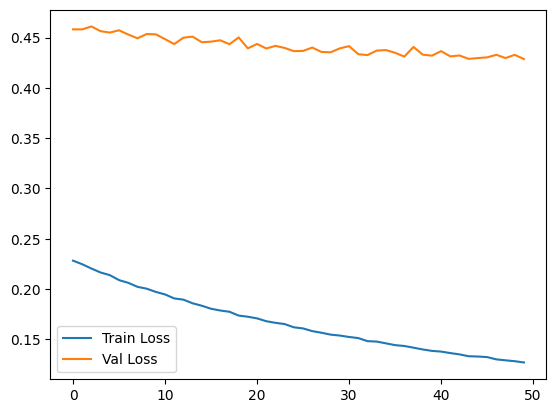

In [ ]:
fig, ax = plt.subplots()

ax.plot(np.arange(num_epochs), train_losses)
ax.plot(np.arange(num_epochs), val_losses)
ax.legend(['Train Loss', 'Val Loss'])

In [ ]:
from google.colab import files
files.download('/content/content/inceptionV3proyecto.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Predictions (yeaah)

In [ ]:
model_path = '/content/drive/MyDrive/proyecto_inteligencia/model_vggH2_FE_F.pth'

In [ ]:
model = torch.load(model_path)

In [ ]:
predictions = []

with torch.no_grad():
    for inputs, _ in val_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        predictions.extend(preds.tolist())

In [ ]:
print(predictions)

[0, 0, 5, 3, 5, 5, 0, 1, 4, 1, 5, 2, 1, 4, 3, 0, 0, 5, 5, 5, 2, 1, 2, 1, 3, 0, 0, 3, 5, 3, 1, 2, 5, 4, 3, 1, 5, 4, 5, 3, 0, 1, 4, 1, 4, 3, 4, 4, 3, 3, 5, 2, 4, 2, 5, 1, 0, 4, 3, 3, 2, 1, 1, 1, 4, 0, 5, 3, 5, 4, 5, 4, 0, 1, 0, 5, 5, 4, 1, 2, 1, 4, 2, 5, 5, 5, 5, 5, 5, 4, 0, 1, 3, 5, 0, 2, 4, 5, 1, 3, 2, 3, 3, 0, 2, 3, 5, 3, 4, 5, 3, 5, 5, 1, 4, 3, 4, 3, 3, 3, 0, 2, 4, 3, 4, 5, 5, 4, 4, 2, 3, 0, 3, 5, 3, 3, 5, 5, 0, 1, 4, 1, 3, 5, 3, 5, 2, 5, 4, 4, 3, 5, 5, 0, 5, 3, 1, 3, 5, 2, 5, 3, 5, 1, 2, 3, 1, 1, 3, 3, 2, 3, 4, 5, 5, 2, 0, 4, 3, 4, 4, 3, 5, 3, 5, 4, 2, 1, 0, 4, 2, 0, 0, 2, 2, 2, 1, 4, 3, 3, 5, 1, 4, 1, 1, 1, 1, 5, 2, 3, 4, 2, 1, 2, 1, 2, 5, 5, 1, 2, 3, 5, 5, 4, 0, 1, 5, 0, 4, 0, 0, 5, 5, 4, 3, 2, 2, 1, 3, 1, 3, 5, 3, 1, 3, 2, 0, 4, 0, 5, 0, 0, 4, 5, 4, 4, 5, 1, 3, 4, 3, 1, 0, 5, 5, 1, 1, 4, 4, 0, 4, 0, 3, 3, 0, 4, 3, 0, 3, 3, 0, 5, 4, 4, 4, 5, 5, 3, 1, 0, 3, 5, 1, 3, 2, 2, 4, 3, 5, 5, 3, 5, 4, 3, 5, 4, 3, 3, 0, 3, 0, 2, 2, 0, 0, 1, 5, 3, 4, 3, 4, 5, 1, 5, 2, 0, 3, 5, 5, 4, 3, 4, 1, 

In [ ]:
pred = np.array(predictions)

pred += 1
print(pred)

[1 1 6 ... 6 5 6]


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score

confusion_matrix_train = confusion_matrix(val_labels, pred, normalize="true")
accuracy_train = accuracy_score(val_labels, pred)



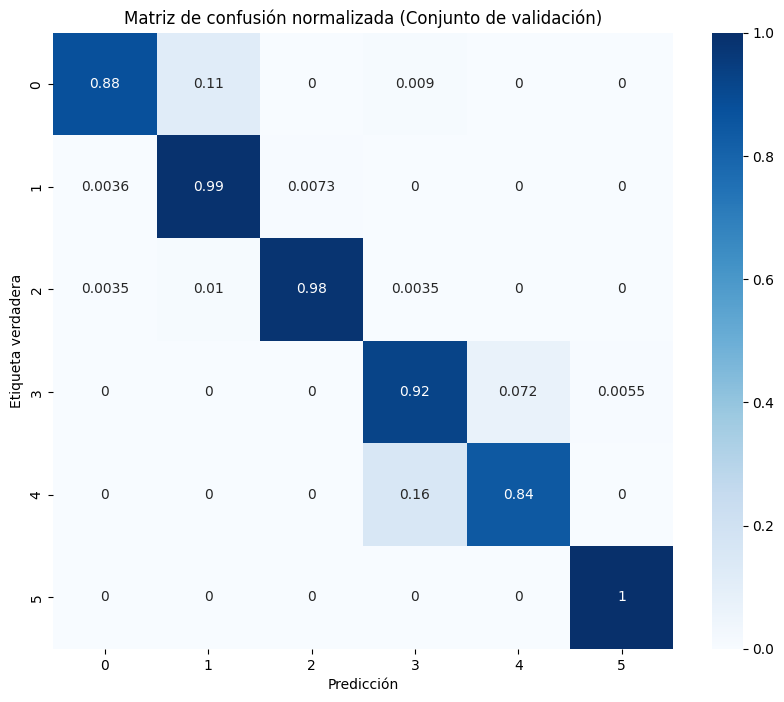

Accuracy en el conjunto de validación: 0.933


In [ ]:
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix_train, annot=True, cmap="Blues")
plt.title("Normalized confusion matrix (Validation set)")
plt.xlabel("Prediction")
plt.ylabel("True Label")
plt.show()

print("Accuracy in validation set", accuracy_train)

## Test Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/MyDrive/proyecto_inteligencia/heatmap2/prueba.zip'

Archive:  /content/drive/MyDrive/proyecto_inteligencia/heatmap2/prueba.zip
   creating: content/prueba/
  inflating: content/prueba/pru_0035.png  
  inflating: content/prueba/pru_1031.png  
  inflating: content/prueba/pru_1693.png  
  inflating: content/prueba/pru_1847.png  
  inflating: content/prueba/pru_0176.png  
  inflating: content/prueba/pru_0711.png  
  inflating: content/prueba/pru_1360.png  
  inflating: content/prueba/pru_1965.png  
  inflating: content/prueba/pru_1968.png  
  inflating: content/prueba/pru_1008.png  
  inflating: content/prueba/pru_0355.png  
  inflating: content/prueba/pru_0060.png  
  inflating: content/prueba/pru_0252.png  
  inflating: content/prueba/pru_0266.png  
  inflating: content/prueba/pru_0656.png  
  inflating: content/prueba/pru_0081.png  
  inflating: content/prueba/pru_0594.png  
  inflating: content/prueba/pru_1380.png  
  inflating: content/prueba/pru_1511.png  
  inflating: content/prueba/pru_1431.png  
  inflating: content/prueba/pru_0379

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, image_folder, label_file, transform=None, is_train=True):
        self.image_folder = image_folder
        self.labels = np.load(label_file) - 1
        self.transform = transform
        self.is_train = is_train

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        if self.is_train:
            img_path = self.image_folder + '/ent_{:04d}.png'.format(index)
        else:
            img_path = self.image_folder + '/pru_{:04d}.png'.format(index)

        image = Image.open(img_path)
        label = self.labels[index]

        if self.transform is not None:
            image = self.transform(image)

        return image, label

In [ ]:
# Transformaciones de las imágenes (sin data augmentation)
transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Rutas de las carpetas y archivos
test_folder = '/content/content/prueba'

# Rutas de las carpetas y archivos
train_folder = '/content/content/entrenamiento'
train_labels_file = '/content/drive/MyDrive/proyecto_inteligencia/train_labels.npy'
val_folder = '/content/content/validacion'
val_labels_file = '/content/drive/MyDrive/proyecto_inteligencia/val_labels.npy'

In [ ]:
test_dataset = CustomDataset(test_folder, val_labels_file, transform, is_train=False) #ojo, hay que poner etiquetas, pero estas no se usarán

In [ ]:
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
model_path = '/content/drive/MyDrive/proyecto_inteligencia/model_vggH2_3.pth'

In [ ]:
model = torch.load(model_path)

In [ ]:
predictions = []

with torch.no_grad():
    for inputs, _ in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        predictions.extend(preds.tolist())

In [ ]:
print(predictions)

[2, 4, 3, 1, 4, 1, 3, 4, 2, 0, 3, 3, 4, 0, 1, 2, 0, 3, 5, 3, 5, 3, 4, 1, 5, 3, 3, 3, 3, 3, 5, 5, 3, 1, 3, 2, 0, 4, 5, 0, 4, 5, 1, 3, 0, 5, 5, 1, 2, 5, 4, 5, 0, 2, 3, 5, 2, 1, 3, 0, 2, 1, 1, 4, 0, 4, 1, 0, 2, 3, 5, 3, 4, 0, 3, 0, 3, 5, 1, 0, 3, 3, 3, 1, 0, 5, 0, 1, 4, 2, 0, 2, 3, 3, 5, 0, 0, 3, 5, 0, 2, 5, 2, 5, 1, 0, 0, 5, 4, 0, 0, 3, 1, 2, 1, 0, 1, 4, 5, 2, 0, 2, 5, 5, 5, 3, 5, 1, 3, 3, 5, 3, 5, 0, 1, 3, 0, 5, 3, 2, 3, 3, 3, 5, 5, 2, 3, 1, 3, 1, 1, 1, 5, 2, 2, 2, 3, 3, 5, 5, 3, 5, 3, 4, 0, 4, 1, 2, 3, 3, 2, 0, 3, 2, 2, 2, 5, 3, 0, 4, 3, 5, 3, 5, 5, 5, 1, 3, 4, 5, 5, 5, 1, 3, 5, 0, 0, 1, 3, 5, 4, 0, 4, 2, 5, 2, 0, 2, 1, 3, 0, 0, 1, 5, 0, 5, 0, 0, 4, 3, 0, 2, 2, 0, 1, 5, 4, 3, 1, 1, 1, 3, 5, 1, 1, 0, 5, 4, 1, 5, 3, 0, 1, 3, 5, 3, 3, 4, 0, 5, 5, 1, 2, 2, 3, 5, 1, 3, 5, 2, 2, 0, 2, 3, 4, 2, 3, 3, 5, 5, 5, 0, 5, 3, 1, 2, 5, 3, 1, 5, 1, 2, 4, 4, 0, 5, 0, 2, 3, 3, 3, 5, 2, 1, 5, 2, 1, 5, 4, 3, 1, 4, 5, 0, 2, 2, 3, 3, 2, 2, 5, 3, 4, 4, 1, 0, 5, 2, 3, 3, 0, 4, 5, 0, 5, 1, 1, 1, 3, 2, 4, 5, 3, 

In [ ]:
pred = np.array(predictions)

pred += 1
print(pred)

[3 5 4 ... 5 2 5]


In [ ]:
import pandas as pd

# Crear un diccionario con los datos
data = {'Id': range(len(pred)), 'Category': pred}

# Crear un DataFrame a partir del diccionario
df = pd.DataFrame(data)

# Guardar el DataFrame en un archivo CSV
df.to_csv('test_vgg_H2_3.csv', index=False)

##Extra

In [ ]:
!unzip '/content/drive/MyDrive/proyecto_inteligencia/heatmap/validacion.zip'

Archive:  /content/drive/MyDrive/proyecto_inteligencia/heatmap/validacion.zip
   creating: content/validacion/
  inflating: content/validacion/val_1008.png  
  inflating: content/validacion/val_0181.png  
  inflating: content/validacion/val_1849.png  
  inflating: content/validacion/val_0770.png  
  inflating: content/validacion/val_1951.png  
  inflating: content/validacion/val_0578.png  
  inflating: content/validacion/val_0849.png  
  inflating: content/validacion/val_0460.png  
  inflating: content/validacion/val_0432.png  
  inflating: content/validacion/val_0733.png  
  inflating: content/validacion/val_0322.png  
  inflating: content/validacion/val_0737.png  
  inflating: content/validacion/val_0374.png  
  inflating: content/validacion/val_1933.png  
  inflating: content/validacion/val_1103.png  
  inflating: content/validacion/val_1979.png  
  inflating: content/validacion/val_0848.png  
  inflating: content/validacion/val_1354.png  
  inflating: content/validacion/val_0615.pn

In [ ]:
# Transformaciones de las imágenes (sin data augmentation)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    #transforms.Grayscale(),      ###
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

batch_size = 32

# Rutas de las carpetas y archivos

val_folder = '/content/content/validacion'
val_labels_file = '/content/drive/MyDrive/proyecto_inteligencia/val_labels.npy'

In [ ]:
val_dataset = CustomDataset(val_folder, val_labels_file, transform, is_train=False)

In [ ]:
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
model_path = '/content/drive/MyDrive/proyecto_inteligencia/model_vgg_2.pth'
hist_path = '/content/drive/MyDrive/proyecto_inteligencia/hist_vgg_2.pth'
train_l_path = '/content/drive/MyDrive/proyecto_inteligencia/train_loss_vgg_2.pth'
val_l_path = '/content/drive/MyDrive/proyecto_inteligencia/val_loss_vgg_2.pth'

train_l = torch.load(train_l_path)
val_l = torch.load(val_l_path)
num_epochs = 20

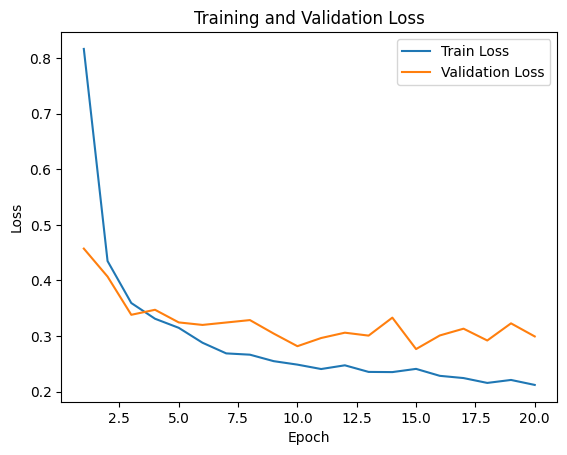

In [ ]:
import matplotlib.pyplot as plt

# Graficar las curvas de pérdida
plt.plot(range(1, num_epochs + 1), train_l, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_l, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
model = torch.load(model_path)

In [ ]:
predictions = []

with torch.no_grad():
    for inputs, _ in val_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        predictions.extend(preds.tolist())

In [ ]:
print(predictions)

[0, 0, 5, 3, 5, 5, 0, 1, 4, 1, 5, 2, 1, 4, 4, 0, 0, 5, 5, 5, 2, 1, 1, 1, 3, 1, 0, 3, 5, 3, 1, 2, 5, 4, 3, 1, 5, 4, 5, 3, 0, 1, 4, 1, 4, 3, 4, 4, 3, 3, 5, 2, 3, 2, 5, 1, 0, 4, 3, 3, 2, 1, 0, 1, 4, 0, 5, 3, 5, 4, 5, 4, 0, 1, 0, 5, 5, 4, 1, 2, 2, 4, 2, 5, 5, 5, 5, 5, 5, 4, 0, 1, 3, 5, 0, 2, 4, 5, 1, 3, 2, 4, 3, 0, 2, 3, 5, 3, 4, 5, 3, 5, 5, 0, 4, 3, 4, 3, 3, 3, 0, 2, 4, 3, 4, 5, 5, 4, 4, 2, 3, 0, 3, 5, 3, 3, 5, 5, 0, 1, 4, 1, 5, 5, 3, 5, 1, 5, 4, 4, 3, 5, 5, 0, 5, 3, 1, 3, 5, 2, 5, 4, 5, 2, 2, 3, 1, 1, 4, 5, 2, 1, 4, 5, 5, 2, 0, 4, 3, 4, 4, 3, 5, 3, 5, 4, 2, 1, 0, 4, 2, 0, 0, 2, 2, 2, 1, 4, 3, 3, 5, 1, 4, 1, 1, 1, 1, 5, 2, 3, 4, 2, 1, 2, 1, 2, 5, 5, 1, 2, 3, 5, 5, 4, 0, 1, 5, 0, 4, 0, 0, 5, 5, 4, 3, 2, 2, 1, 3, 1, 4, 5, 3, 1, 3, 2, 0, 4, 0, 5, 0, 0, 4, 5, 4, 4, 5, 2, 4, 4, 3, 1, 0, 5, 5, 1, 2, 4, 4, 0, 4, 0, 3, 3, 0, 4, 3, 0, 3, 3, 0, 5, 4, 4, 4, 5, 5, 3, 0, 0, 5, 5, 1, 3, 2, 2, 4, 3, 5, 5, 3, 5, 4, 3, 5, 4, 3, 4, 0, 3, 0, 2, 2, 1, 0, 1, 5, 3, 4, 3, 4, 5, 2, 5, 2, 0, 3, 5, 5, 4, 4, 4, 1, 

In [ ]:
pred = np.array(predictions)

pred += 1
print(pred)

[1 1 6 ... 6 5 6]


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score

confusion_matrix_train = confusion_matrix(val_labels, pred, normalize="true")
accuracy_train = accuracy_score(val_labels, pred)



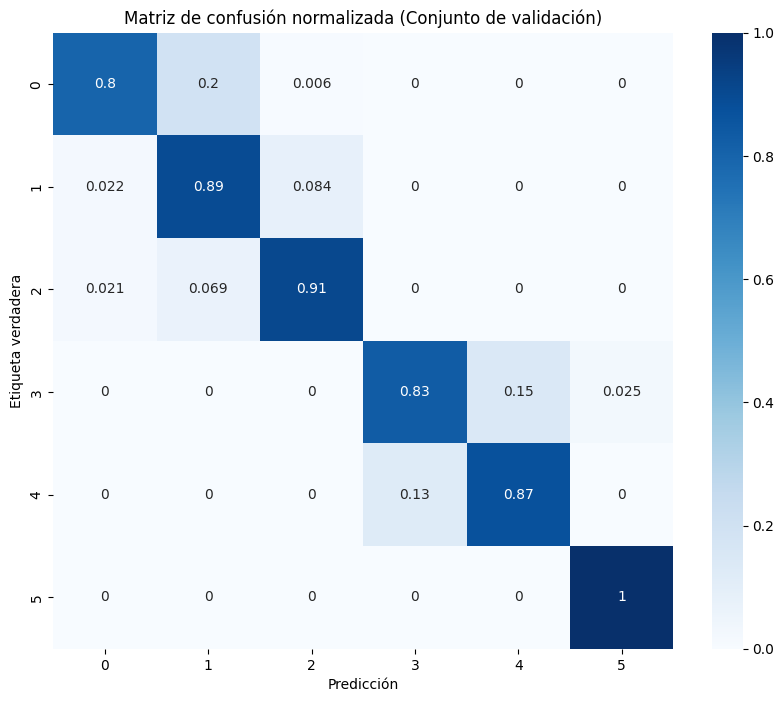

Accuracy en el conjunto de validación: 0.8855


In [ ]:
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix_train, annot=True, cmap="Blues")
plt.title("Matriz de confusión normalizada (Conjunto de validación)")
plt.xlabel("Predicción")
plt.ylabel("Etiqueta verdadera")
plt.show()

print("Accuracy en el conjunto de validación:", accuracy_train)